In [1]:
import cox
from cox.readers import CollectionReader
import os 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from delphi.utils.model_utils import make_and_restore_model
from delphi.utils.datasets import CIFAR

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
ROOT = '/home/gridsan/stefanou/'
EXP = 'identity'
# constants 
BASE_CLASSIFIER = '/base_classifier/'
LOGIT_BALL_CLASSIFIER = '/logit_ball/'
DIFF_TRUNC_SET = '/diff_trunc_set/'

STANDARD_CLASSIFIER = '/standard_classifier/'

In [2]:
def plot(logs, metadata, class_): 
    # iterate over learning rates
#     for i, lr in enumerate(LEARNING_RATES):
    for i, lr in enumerate(np.sort(metadata.lr.unique())): 
        # extract meta logs of interest 
        meta_logs = metadata[(metadata.lr == lr)]        
        
        fig, ax = plt.subplots(2, 2, figsize=(10, 7.5), constrained_layout=True)
#         for j, weight_decay in enumerate(WEIGHT_DECAYS):
        for j, weight_decay in enumerate(meta_logs.weight_decay.unique()):
            lr_logs = logs[logs.exp_id.isin(meta_logs[meta_logs.weight_decay == weight_decay].exp_id)]
            if len(lr_logs) == 0: 
                continue
            # plot loss curves
            sns.lineplot(data=lr_logs, x='epoch', y='train_loss', label='{} weight decay'.format(weight_decay), ax=ax[0, 0])
            sns.lineplot(data=lr_logs, x='epoch', y='val_loss', label='{} weight decay'.format(weight_decay), ax=ax[1, 0])
            
            # plot accuracy curves
            sns.lineplot(data=lr_logs, x='epoch', y='train_prec1', label='{} weight decay'.format(weight_decay), ax=ax[0, 1])
            sns.lineplot(data=lr_logs, x='epoch', y='val_prec1', label='{} weight decay'.format(weight_decay), ax=ax[1, 1])
            
        ax[0, 0].set_title('{} Train Loss: lr - {}'.format(class_, lr))
        ax[0, 0].set_xlabel('Epoch')
        ax[0, 0].set_ylabel('CE Loss')
        ax[1, 0].set_title('{} Validation Loss: lr - {}'.format(class_, lr))
        ax[1, 0].set_xlabel('Epoch')
        ax[1, 0].set_ylabel('CE Loss')
        ax[0, 0].legend()
        ax[1, 0].legend()
        ax[0, 1].set_title('{} Train Accuracy: lr - {}'.format(class_, lr))
        ax[0, 1].set_xlabel('Epoch')
        ax[0, 1].set_ylabel('Accuracy')
        ax[1, 1].set_title('{} Val Accuray: lr - {}'.format(class_, lr))
        ax[1, 1].set_xlabel('Epoch')
        ax[1, 1].set_ylabel('Accuracy')
        ax[0, 1].legend()
        ax[1, 1].legend()
        plt.show()
        
def plot_test_results(base, trunc, standard, type_):
    for i, lr in enumerate(base.lr.unique()): 
        logs_ = base[base.lr == lr].sort_values(by=['weight_decay'])
        trunc_logs_ = trunc[trunc.lr == lr].sort_values(by=['weight_decay'])
        standard_logs_ = standard[standard.lr == lr].sort_values(by=['weight_decay'])
        sns.lineplot(data=logs_, x='weight_decay', y='test_prec1', label='base')
        sns.lineplot(data=trunc_logs_, x='weight_decay', y='test_prec1', label='trunc ce')
        sns.lineplot(data=standard_logs_, x='weight_decay', y='test_prec1', label='standard')
        plt.xlabel('Weight Decay')
        plt.ylabel('Accuracy')
        plt.title('{} Test Accuracy : {} lr'.format(type_, lr))
        plt.legend()
        plt.show()

In [4]:
base_reader = CollectionReader(ROOT + EXP + BASE_CLASSIFIER)
base_logs = base_reader.df('logs')
base_metadata = base_reader.df('metadata')
# unseen = base_reader.df('unseen')
# test = base_reader.df('test')
# trunc_train = base_reader.df('trunc_train')
# train_base = base_reader.df('train_base')
# base_reader.close()

trunc_reader = CollectionReader(ROOT + EXP + LOGIT_BALL_CLASSIFIER)
trunc_logs = trunc_reader.df('logs')
trunc_metadata = trunc_reader.df('metadata')
# trunc_unseen = trunc_reader.df('unseen')
# trunc_test = trunc_reader.df('test')
# trunc_trunc_train = trunc_reader.df('trunc_train')
# trunc_train_base = trunc_reader.df('train_base')
# trunc_reader.close()

# stand_reader = CollectionReader(ROOT + EXP + STANDARD_CLASSIFIER)
# stand_logs = stand_reader.df('logs')
# stand_metadata = stand_reader.df('metadata')
# stand_unseen = stand_reader.df('unseen')
# stand_test = stand_reader.df('test')
# stand_trunc_train = stand_reader.df('trunc_train')
# stand_train_base = stand_reader.df('train_base')
# stand_reader.close()

100%|██████████| 3/3 [00:00<00:00,  8.74it/s]


In [5]:
trunc_cifar_10_1 = trunc_reader.df('cifar-10-1')
cifar_10_1 = base_reader.df('cifar-10-1')
# trunc_metadata[trunc_metadata.exp_id == trunc_cifar_10_1.iloc[trunc_cifar_10_1.test_prec1.argmax()].exp_id]

In [7]:
def plot_weight_decay(metadata, logs_, class_):
    for j, lr in enumerate(metadata.lr.unique()): 

        meta_logs = metadata[metadata.lr == lr]       
        fig, ax = plt.subplots(2, 2, figsize=(10, 7.5), constrained_layout=True)
        for i, wd in enumerate(metadata.weight_decay.unique()): 

            logs = logs_[logs_.exp_id.isin(meta_logs[meta_logs.weight_decay == wd].exp_id)]
            
            sns.lineplot(data=logs, x='epoch', y='train_loss', label='weight decay: {}'.format(wd), ax=ax[0, 0])
            sns.lineplot(data=logs, x='epoch', y='val_loss', label='weight decay: {}'.format(lr), ax=ax[1, 0])


            sns.lineplot(data=logs, x='epoch', y='train_prec1', label='weight decay: {}'.format(wd), ax=ax[0, 1])
            sns.lineplot(data=logs, x='epoch', y='val_prec1', label='weight decay: {}'.format(wd), ax=ax[1, 1])        
        ax[0, 0].set_title('{} train loss: lr - {}'.format(class_, lr))
        ax[0, 0].set_xlabel('epoch')
        ax[0, 0].set_ylabel('ce loss')
        ax[1, 0].set_title('{} validation loss: lr - {}'.format(class_, lr))
        ax[1, 0].set_xlabel('epoch')
        ax[1, 0].set_ylabel('ce loss')
        ax[0, 0].legend()
        ax[1, 0].legend()
        ax[0, 1].set_title('{} train acc: lr - {}'.format(class_, lr))
        ax[0, 1].set_xlabel('epoch')
        ax[0, 1].set_ylabel('acc')
        ax[1, 1].set_title('{} val acc: lr - {}'.format(class_, lr))
        ax[1, 1].set_xlabel('epoch')
        ax[1, 1].set_ylabel('acc')
        ax[0, 1].legend()
        ax[1, 1].legend()
        plt.show()        

<AxesSubplot:xlabel='epoch', ylabel='train_prec1'>

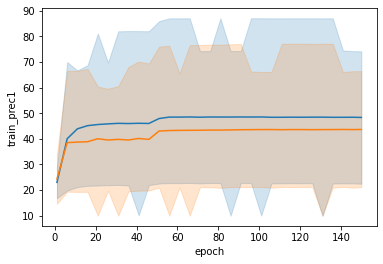

In [11]:
sns.lineplot(data=base_logs, x='epoch', y='train_prec1')
sns.lineplot(data=base_logs, x='epoch', y='val_prec1')

In [12]:
def filter_func(metadata, unseen, train_base, test, trunc_train):
    for i, norm in enumerate(np.sort(trunc_metadata.logit_ball.unique())): 
        unseen_logs = unseen[unseen.exp_id.isin(metadata[metadata.logit_ball == norm].exp_id)]
        unseen_stand_logs_ = unseen[unseen.exp_id.isin(metadata[metadata.logit_ball == norm].exp_id)]

        # use .apply() to find exp id for every experiment                       
        unseen['logit_ball'] =  unseen.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['logit_ball'], axis=1)
        test['logit_ball'] = test.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['logit_ball'], axis=1)
        trunc_train['logit_ball'] = trunc_train.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['logit_ball'], axis=1)
        train_base['logit_ball'] = train_base.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['logit_ball'], axis=1)
      
    for i, wd in enumerate(trunc_metadata.weight_decay.unique()): 
        unseen_logs = unseen[unseen.exp_id.isin(metadata[metadata.weight_decay == wd].exp_id)]
        unseen_stand_logs_ = unseen[unseen.exp_id.isin(metadata[metadata.weight_decay == wd].exp_id)]

        # use .apply() to find exp id for every experiment                       
        unseen['weight_decay'] =  unseen.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['weight_decay'], axis=1)
        test['weight_decay'] = test.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['weight_decay'], axis=1)
        trunc_train['weight_decay'] = trunc_train.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['weight_decay'], axis=1)
        train_base['weight_decay'] = train_base.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['weight_decay'], axis=1)
        
    return unseen, test, trunc_train, train_base
    
    
    
trunc_unseen_, trunc_test_, trunc_train_, trunc_train_base_ = filter_func(trunc_metadata, trunc_unseen, trunc_train_base, trunc_test, trunc_train_base)

stand_unseen_, stand_test_, stand_train_, stand_train_base_ = filter_func(stand_metadata, stand_unseen, stand_train_base, stand_test, stand_train_base)

base_unseen_, base_test_, base_train_, base_train_base_ = filter_func(base_metadata, unseen, train_base, test, train_base)

NameError: name 'trunc_unseen' is not defined

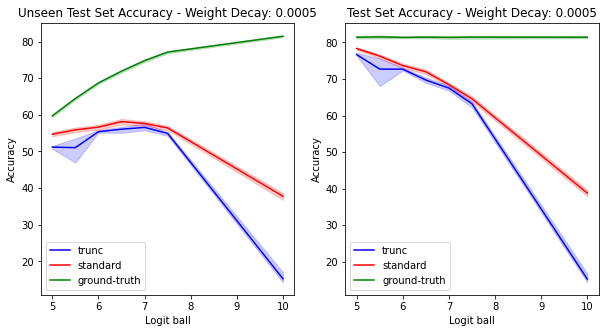

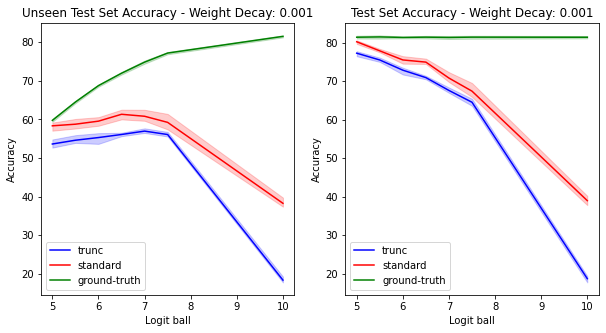

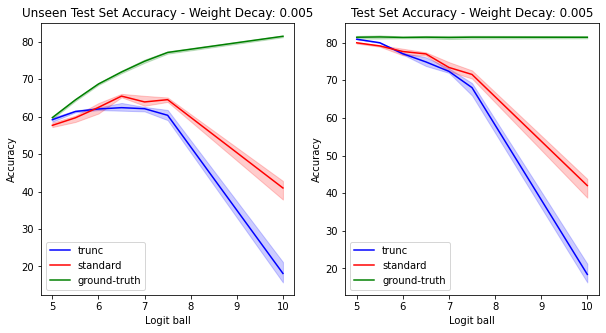

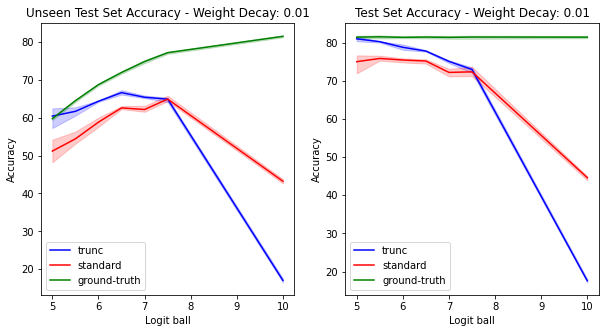

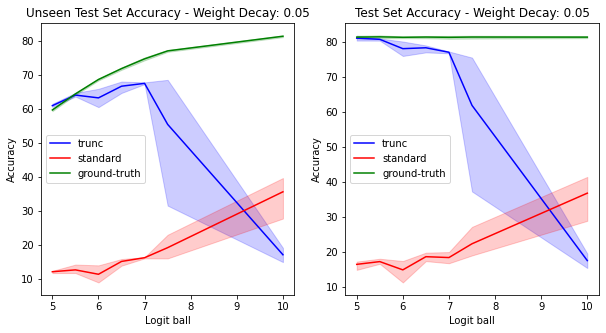

In [42]:
for i, wd in enumerate(np.sort(trunc_metadata.weight_decay.unique())):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    t_unseen_ = trunc_unseen_[trunc_unseen_.weight_decay == wd]
    t_test_ = trunc_test_[trunc_test_.weight_decay == wd]
    s_unseen_ = stand_unseen_[stand_unseen_.weight_decay == wd]
    s_test_ = stand_test_[stand_test_.weight_decay == wd]


    sns.lineplot(data=t_unseen_, x='logit_ball', y='test_prec1', label='trunc', color='blue', ax=ax[0])
    sns.lineplot(data=s_unseen_, x='logit_ball', y='test_prec1', label='standard', color='red', ax=ax[0])
    sns.lineplot(data=base_unseen_, x='logit_ball', y='test_prec1', label='ground-truth', color='green', ax=ax[0])
    ax[0].set_xlabel('Logit ball')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Unseen Test Set Accuracy - Weight Decay: {}'.format(wd))

    sns.lineplot(data=t_test_, x='logit_ball', y='test_prec1', label='trunc', color='blue', ax=ax[1])
    sns.lineplot(data=s_test_, x='logit_ball', y='test_prec1', label='standard', color='red', ax=ax[1])
    sns.lineplot(data=base_test_, x='logit_ball', y='test_prec1', label='ground-truth', color='green', ax=ax[1])
    ax[1].set_xlabel('Logit ball')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Test Set Accuracy - Weight Decay: {}'.format(wd))
    plt.show()

In [43]:
filter_ = lambda x: x[x.logit_ball <= 7.5]
best_trunc_unseen_ = filter_(trunc_unseen_[trunc_unseen_.weight_decay == .05])
best_stand_unseen_ = filter_(stand_unseen_[stand_unseen_.weight_decay == .005])

best_trunc_test_ = filter_(trunc_test_[trunc_test_.weight_decay == .05])
best_stand_test_ = filter_(stand_test_[stand_test_.weight_decay == .005])

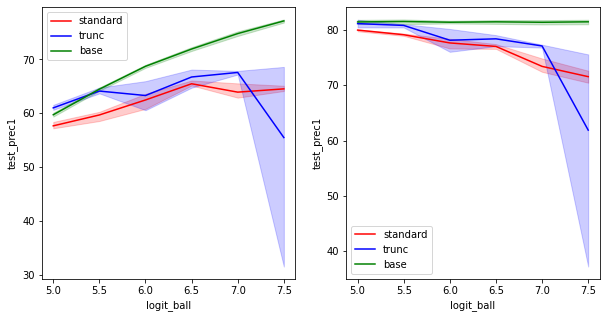

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=best_stand_unseen_, x='logit_ball', y='test_prec1', label='standard', color='red', ax=ax[0])
sns.lineplot(data=best_trunc_unseen_, x='logit_ball', y='test_prec1', label='trunc', color='blue', ax=ax[0])
sns.lineplot(data=filter_(base_unseen_), x='logit_ball', y='test_prec1', label='base', color='green', ax=ax[0])

sns.lineplot(data=best_stand_test_, x='logit_ball', y='test_prec1', label='standard', color='red', ax=ax[1])
sns.lineplot(data=best_trunc_test_, x='logit_ball', y='test_prec1', label='trunc', color='blue', ax=ax[1])
sns.lineplot(data=filter_(base_test_), x='logit_ball', y='test_prec1', label='base', color='green', ax=ax[1])
plt.show()



In [34]:
for i, norm in enumerate(trunc_metadata.logit_ball.unique()): 
    logs = trunc_logs[trunc_logs.exp_id.isin(trunc_metadata[trunc_metadata.logit_ball == norm].exp_id)]
    stand_logs_ = standard_logs[standard_logs.exp_id.isin(standard_metadata[standard_metadata.logit_ball == norm].exp_id)]
    sns.lineplot(data=logs, x='epoch', y='train_prec1', label='trunc train acc: {}'.format(norm))
    sns.lineplot(data=logs, x='epoch', y='val_prec1', label='trunc val acc: {}'.format(norm))
    sns.lineplot(data=stand_logs_, x='epoch', y='train_prec1', label='standard train acc: {}'.format(norm))
    sns.lineplot(data=stand_logs_, x='epoch', y='val_prec1', label='standard val acc: {}'.format(norm))
    plt.title('Norm: {}'.format(norm))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    


NameError: name 'standard_logs' is not defined

In [5]:
N = 10

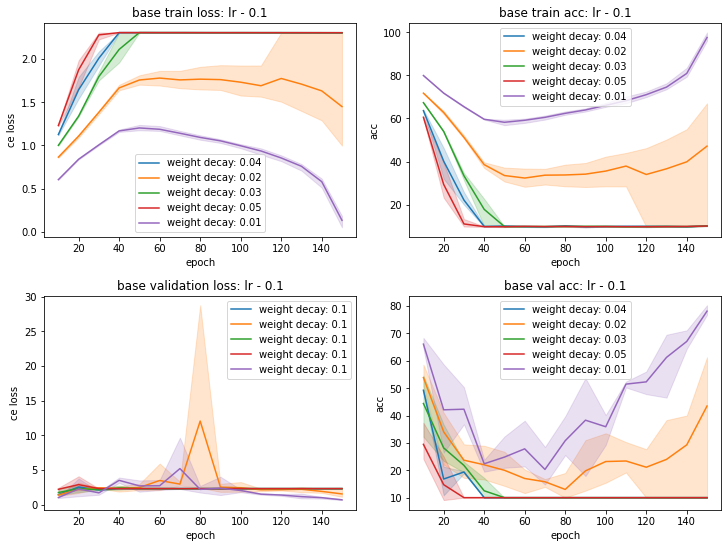

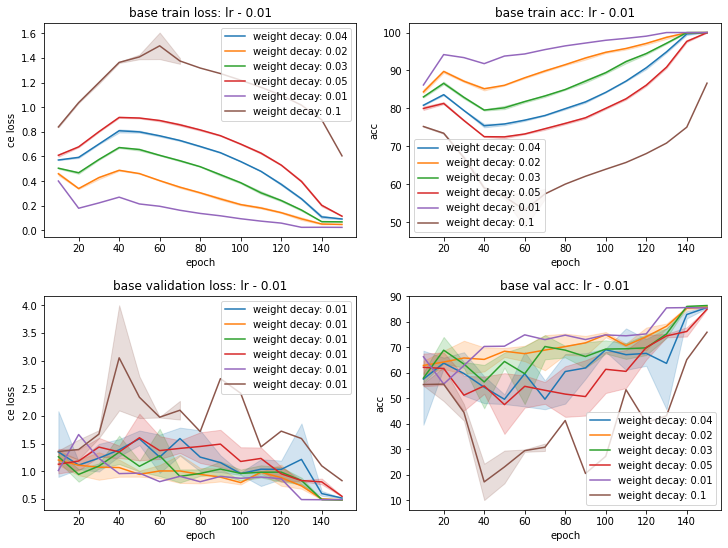

In [133]:
plot_weight_decay(base_metadata, base_logs[base_logs['epoch'] % N == 0], 'base')

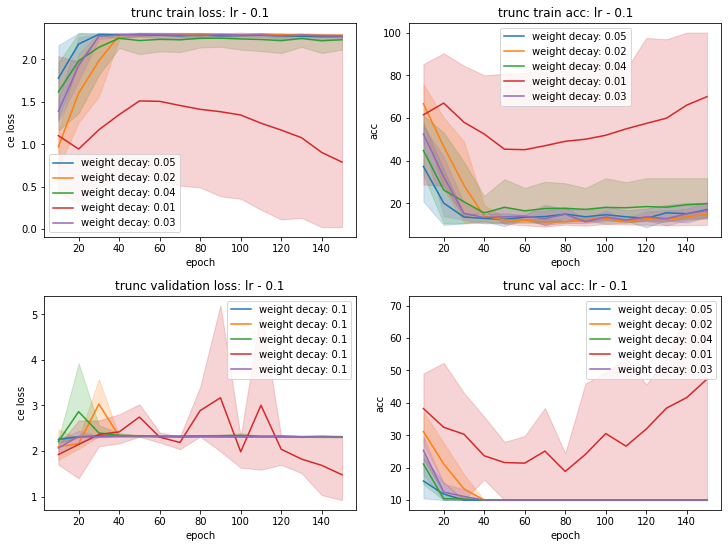

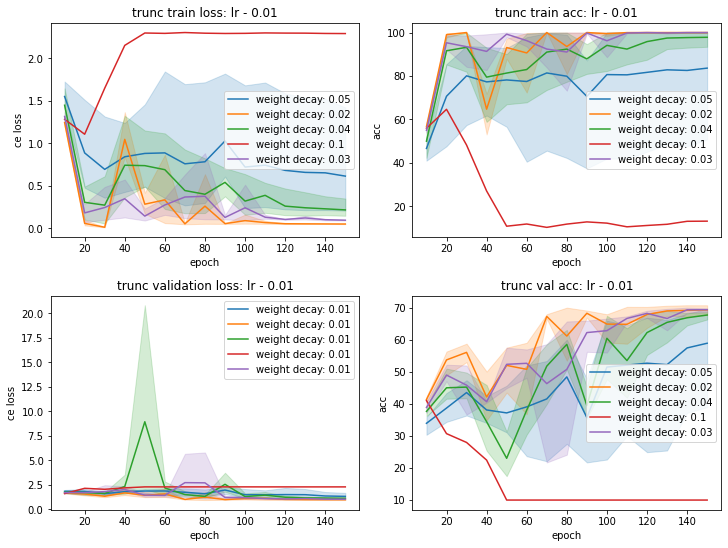

In [134]:
plot_weight_decay(trunc_metadata, trunc_logs[trunc_logs['epoch'] % N == 0], 'trunc')

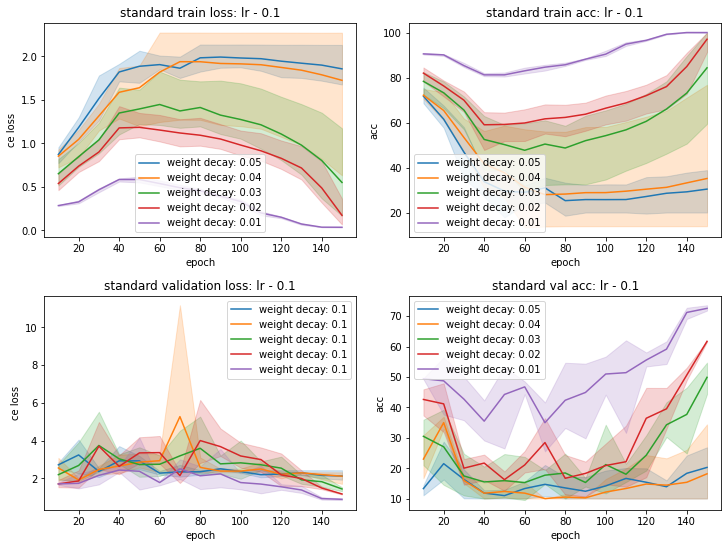

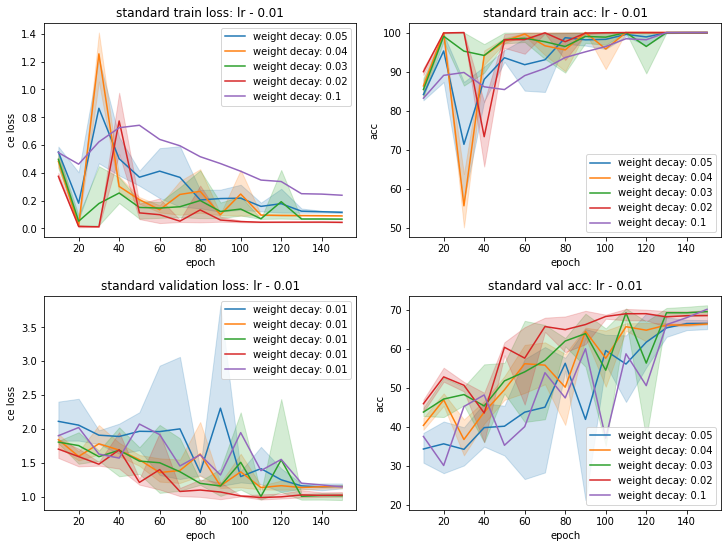

In [135]:
plot_weight_decay(standard_metadata, standard_logs[standard_logs.epoch % 10 == 0], 'standard')

In [136]:
def plot_test_results_(base, trunc, standard, type_):
#     for i, wd in enumerate(base.weight_decay.unique()): 
    for j, lr in enumerate(base.lr.unique()):
        logs_ = base[base.lr == lr].sort_values(by=['weight_decay'])
        trunc_logs_ = trunc[trunc.lr == lr].sort_values(by=['weight_decay'])
        standard_logs_ = standard[standard.lr == lr].sort_values(by=['weight_decay'])
        sns.lineplot(data=logs_, x='weight_decay', y='test_prec1', label='base', color='red')
        sns.lineplot(data=trunc_logs_, x='weight_decay', y='test_prec1', label='trunc ce')
        sns.lineplot(data=standard_logs_, x='weight_decay', y='test_prec1', label='standard')
        plt.xlabel('weight decay')
        plt.ylabel('acc')
        plt.title('lr: {} - {} acc'.format(lr, type_))
        plt.legend()
        plt.show()

In [137]:
# iterate over learning rates
def filter_(metadata, unseen, test, trunc_train, train_base):
    for i, weight_decay in enumerate(metadata.weight_decay.unique()): 
        # use .apply() to find exp id for every experiment                       
        unseen['weight_decay'] =  unseen.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['weight_decay'], axis=1)
        test['weight_decay'] = test.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['weight_decay'], axis=1)
        trunc_train['weight_decay'] = trunc_train.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['weight_decay'], axis=1)
        train_base['weight_decay'] = train_base.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['weight_decay'], axis=1)
    
    # iterate over learning rates
    for i, mom in enumerate(metadata.momentum.unique()): 
        # use .apply() to find exp id for every experiment                       
        unseen['momentum'] =  unseen.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['momentum'], axis=1)
        test['momentum'] = test.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['momentum'], axis=1)
        trunc_train['momentum'] = trunc_train.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['momentum'], axis=1)
        train_base['momentum'] = train_base.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['momentum'], axis=1)
        
    # iterate over learning rates
    for i, lr in enumerate(metadata.lr.unique()): 

        # use .apply() to find exp id for every experiment                       
        unseen['lr'] =  unseen.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['lr'], axis=1)
        test['lr'] = test.apply(lambda row: metadata[metadata.exp_id == row['exp_id']]['lr'], axis=1)
        trunc_train['lr'] = trunc_train.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['lr'], axis=1)
        train_base['lr'] = train_base.apply(lambda row: metadata[metadata.exp_id == row.exp_id]['lr'], axis=1)
        

    return unseen, test, trunc_train, train_base

unseen_, test_, trunc_train_, train_base_ = filter_(base_metadata, unseen, test, trunc_train, train_base)
trunc_unseen_, trunc_test_, trunc_trunc_train_, trunc_train_base_ = filter_(trunc_metadata, trunc_unseen, trunc_test, trunc_trunc_train, trunc_train_base)
standard_unseen_, standard_test_, standard_trunc_train_, standard_train_base_ = filter_(standard_metadata, standard_unseen, standard_test, standard_trunc_train, standard_train_base)

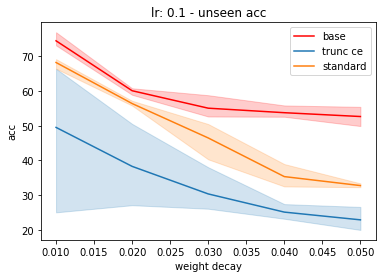

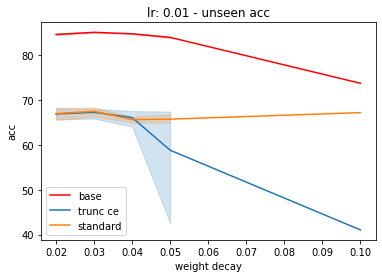

In [138]:
plot_test_results_(unseen_, trunc_unseen_, standard_unseen_, 'unseen')

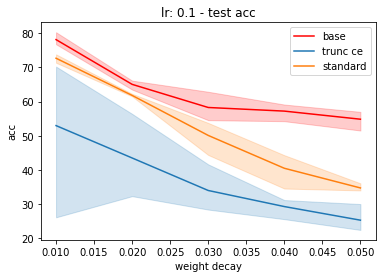

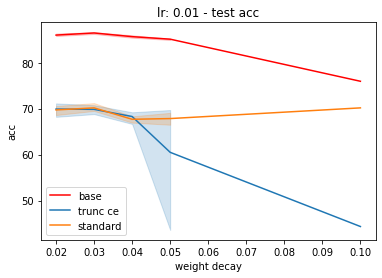

In [139]:
plot_test_results_(test_, trunc_test_, standard_test_, 'test')

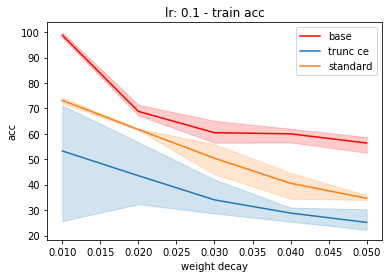

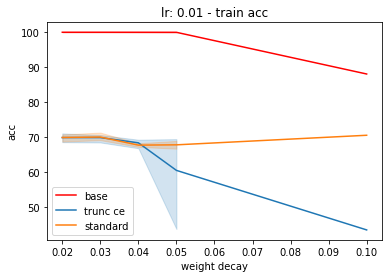

In [140]:
plot_test_results_(train_base_, trunc_train_base_, standard_train_base_, 'train')

In [13]:
# plot training/validation curves
def plot_cifar_10_1(logs, cifar_10_1, trunc_logs, trunc_cifar_10_1): 
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(15)

    fig.add_subplot(1, 2, 1)
    sns.lineplot(data=logs, x='epoch', y='train_prec1', label='train', color='blue')
    sns.lineplot(data=logs, x='epoch', y='val_prec1', label='val', color='red')
    sns.lineplot(data=cifar_10_1, x='epoch', y='test_prec1', label='CIFAR 10.1', color='green')

    sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', label='trunc train', color='blue', linestyle='dashed')
    sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', label='trunc val', color='red', linestyle='dashed')
    sns.lineplot(data=trunc_cifar_10_1, x='epoch', y='test_prec1', label='trunc CIFAR 10.1', color='green', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')

    fig.add_subplot(1, 2, 2)
    sns.lineplot(data=logs, x='epoch', y='train_loss', label='train', color='blue', linestyle='dashed')
    sns.lineplot(data=logs, x='epoch', y='val_loss', label='val', color='red', linestyle='dashed')
    sns.lineplot(data=cifar_10_1, x='epoch', y='test_loss', label='CIFAR 10.1', color='green', linestyle='dashed')

    sns.lineplot(data=trunc_logs, x='epoch', y='train_loss', label='trunc train', color='blue', linestyle='dashed')
    sns.lineplot(data=trunc_logs, x='epoch', y='val_loss', label='trunc val', color='red', linestyle='dashed')
    sns.lineplot(data=trunc_cifar_10_1, x='epoch', y='test_loss', label='trunc CIFAR 10.1', color='green', linestyle='dashed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')

In [19]:
cifar_10_1 = base_reader.df('cifar-10-1')
cifar_10_1 = base_reader.df('cifar-10-1')
cifar_10_1['epoch'] = (cifar_10_1.index) % 150

In [20]:
trunc_cifar_10_1 = trunc_reader.df('cifar-10-1')
trunc_cifar_10_1 = trunc_reader.df('cifar-10-1')
trunc_cifar_10_1['epoch'] = (trunc_cifar_10_1.index) % 150

Trunc CIFAR_10.1 Max Prec1: 77.10000610351562
Base CIFAR_10.1 Max Prec1: 74.95000457763672


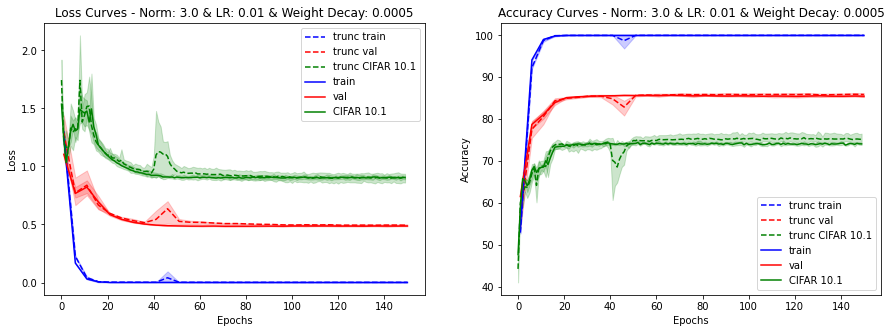

Trunc CIFAR_10.1 Max Prec1: 76.25
Base CIFAR_10.1 Max Prec1: 76.05000305175781


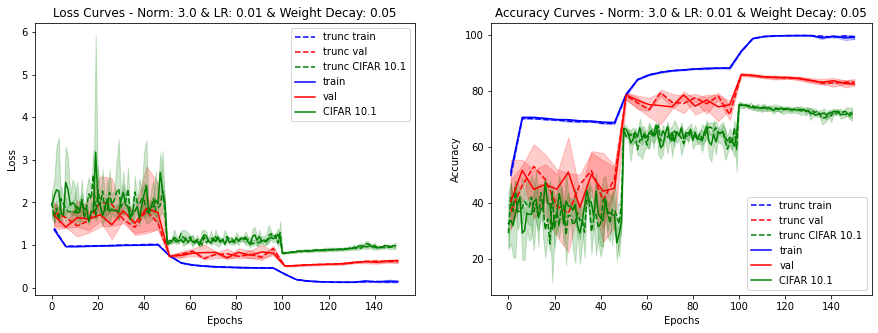

Trunc CIFAR_10.1 Max Prec1: 76.25
Base CIFAR_10.1 Max Prec1: 79.10000610351562


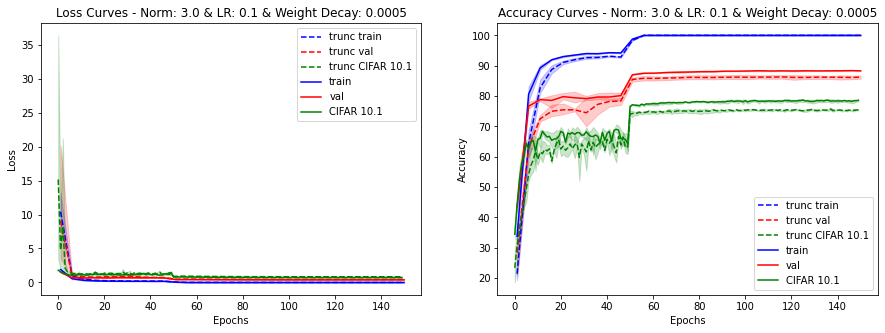

Trunc CIFAR_10.1 Max Prec1: 14.40000057220459
Base CIFAR_10.1 Max Prec1: 13.65000057220459


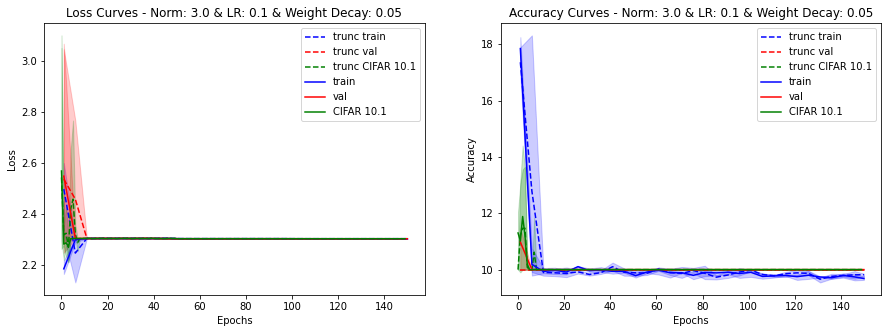

Trunc CIFAR_10.1 Max Prec1: 75.70000457763672
Base CIFAR_10.1 Max Prec1: 75.10000610351562


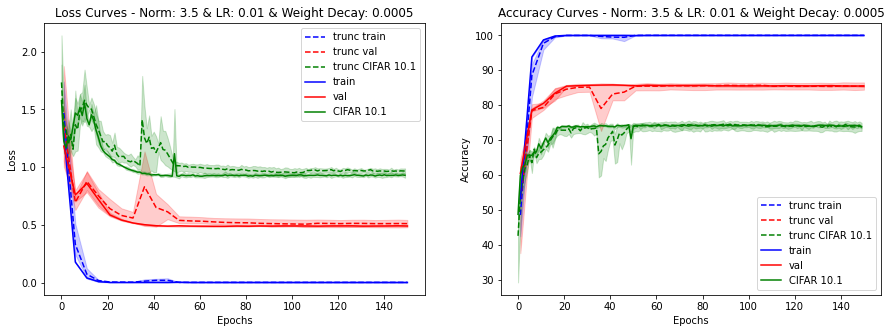

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

In [16]:
for i, norm in enumerate(sorted(trunc_metadata.logit_ball.unique())):
    for j, lr in enumerate(sorted(trunc_metadata.lr.unique())):
        for k, wd in enumerate(sorted(trunc_metadata.weight_decay.unique())):
            fig = plt.figure()
            fig.set_figheight(5)
            fig.set_figwidth(15)


            trunc_exp_ids, base_exp_ids = trunc_metadata[(trunc_metadata.logit_ball == norm) & (trunc_metadata.lr == lr) & (trunc_metadata.weight_decay == wd)].exp_id, base_metadata[(base_metadata.logit_ball == norm) & (base_metadata.lr == lr) & (base_metadata.weight_decay == wd)].exp_id  
                
            # if no experiment, continue to next set of parameters
            if len(trunc_exp_ids) == 0 or len(base_exp_ids) == 0: 
                continue
                
            trunc_logs_, base_logs_ = trunc_logs[trunc_logs.exp_id.isin(trunc_exp_ids)], base_logs[base_logs.exp_id.isin(base_exp_ids)]
            trunc_cf1, base_cf1 = trunc_cifar_10_1[trunc_cifar_10_1.exp_id.isin(trunc_exp_ids)], cifar_10_1[cifar_10_1.exp_id.isin(base_exp_ids)]
            
            fig.add_subplot(1, 2, 1)
            sns.lineplot(data=trunc_logs_, x='epoch', y='train_loss', label='trunc train', color='blue', linestyle='dashed')
            sns.lineplot(data=trunc_logs_, x='epoch', y='val_loss', label='trunc val', color='red', linestyle='dashed')
            sns.lineplot(data=trunc_cf1, x='epoch', y='test_loss', label='trunc CIFAR 10.1', color='green', linestyle='dashed')

            sns.lineplot(data=base_logs_, x='epoch', y='train_loss', label='train', color='blue')
            sns.lineplot(data=base_logs_, x='epoch', y='val_loss', label='val', color='red')
            sns.lineplot(data=base_cf1, x='epoch', y='test_loss', label='CIFAR 10.1', color='green')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Loss Curves - Norm: {} & LR: {} & Weight Decay: {}'.format(norm, lr, wd))

            fig.add_subplot(1, 2, 2)
            sns.lineplot(data=trunc_logs_, x='epoch', y='train_prec1', label='trunc train', color='blue', linestyle='dashed')
            sns.lineplot(data=trunc_logs_, x='epoch', y='val_prec1', label='trunc val', color='red', linestyle='dashed')
            sns.lineplot(data=trunc_cf1, x='epoch', y='test_prec1', label='trunc CIFAR 10.1', color='green', linestyle='dashed')
    
            print("Trunc CIFAR_10.1 Max Prec1: {}".format(trunc_cf1.test_prec1.max()))
            print("Base CIFAR_10.1 Max Prec1: {}".format(base_cf1.test_prec1.max()))
            
            sns.lineplot(data=base_logs_, x='epoch', y='train_prec1', label='train', color='blue')
            sns.lineplot(data=base_logs_, x='epoch', y='val_prec1', label='val', color='red')
            sns.lineplot(data=base_cf1, x='epoch', y='test_prec1', label='CIFAR 10.1', color='green')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.title('Accuracy Curves - Norm: {} & LR: {} & Weight Decay: {}'.format(norm, lr, wd))
            plt.show()

In [5]:
# extract the best performance results on CIFAR-10.1
best_trunc_cifar_10_1, best_cifar_10_1 = trunc_cifar_10_1.groupby('exp_id').max('test_prec1'), cifar_10_1.groupby('exp_id').max('test_prec1')

# dataframe to store experiment results
wd_df = pd.DataFrame(columns=['trunc_exp_id', 'stand_exp_id', 'trunc_prec1', 'stand_prec1', 'trunc_lr', 'stand_lr', 'weight_decay', 'norm'])
lr_df = pd.DataFrame(columns=['trunc_exp_id', 'stand_exp_id', 'trunc_prec1', 'stand_prec1', 'trunc_weight_decay', 'stand_weight_decay', 'lr', 'norm'])


# iterate over logit ball norms
for i, norm in enumerate(sorted(trunc_metadata.logit_ball.unique())): 
    # iterate over weight decay values
    for j, wd in enumerate(sorted(trunc_metadata.weight_decay.unique())):
        # extract experiment ids for hyperparameters
        trunc_norm_exp = trunc_metadata[(trunc_metadata.logit_ball == norm) & (trunc_metadata.weight_decay == wd)].exp_id
        base_exp = base_metadata[base_metadata.weight_decay == wd].exp_id
        
        trunc_idx, base_idx = best_trunc_cifar_10_1.loc[trunc_norm_exp].test_prec1.idxmax(), best_cifar_10_1.loc[base_exp].test_prec1.idxmax()
        
        trunc_lr, stand_lr = trunc_metadata[trunc_metadata.exp_id == trunc_idx].lr.item(), base_metadata[base_metadata.exp_id == base_idx].lr.item()
        stand_prec1, trunc_prec1 = best_cifar_10_1.loc[base_idx].test_prec1, best_trunc_cifar_10_1.loc[trunc_idx].test_prec1


        wd_df = wd_df.append({'trunc_exp_id': trunc_idx, 'stand_exp_id': base_idx, 'norm': norm, 'trunc_lr': trunc_lr, 
                     'stand_lr': stand_lr, 'trunc_prec1': trunc_prec1, 
                     'stand_prec1': stand_prec1, 'weight_decay': wd}, ignore_index=True)
        
        print("Norm: {}".format(norm))
        print("Fixed Weight Decay: {}".format(wd))
        print("Best Truncated Result: {}".format(trunc_prec1))
        print("Best Truncated Learning Rate: {}".format(trunc_lr))
        print("Best Standard Result: {}".format(stand_prec1))
        print("Best Standard Learning Rate: {}".format(stand_lr))

    for j, lr in enumerate(sorted(trunc_metadata.lr.unique())):
        # extract experiment ids for hyperparameters
        trunc_norm_exp = trunc_metadata[(trunc_metadata.logit_ball == norm) & (trunc_metadata.lr == lr)].exp_id
        base_exp = base_metadata[base_metadata.lr == lr].exp_id
        
        trunc_idx, base_idx = best_trunc_cifar_10_1.loc[trunc_norm_exp].test_prec1.idxmax(), best_cifar_10_1.loc[base_exp].test_prec1.idxmax()
        
        trunc_wd, stand_wd = trunc_metadata[trunc_metadata.exp_id == trunc_idx].weight_decay.item(), base_metadata[base_metadata.exp_id == base_idx].weight_decay.item()
        stand_prec1, trunc_prec1 = best_cifar_10_1.loc[base_idx].test_prec1, best_trunc_cifar_10_1.loc[trunc_idx].test_prec1

        # append tuning data to dataframe
        lr_df = lr_df.append({ 
            'trunc_exp_id': trunc_idx, 'stand_exp_id': base_idx, 'norm': norm, 'trunc_weight_decay': trunc_wd, 
            'stand_weight_decay': stand_wd, 'lr': lr, 'trunc_prec1': trunc_prec1, 'stand_prec1': stand_prec1

        }, ignore_index=True)
        
        print("Norm: {}".format(norm))
        print("Fixed Learning Rate: {}".format(lr))
        print("Best Truncated Result: {}".format(trunc_prec1))
        print("Best Truncated Weight Decay: {}".format(trunc_wd))
        print("Best Standard Result: {}".format(stand_prec1))
        print("Best Standard Weight Decay: {}".format(stand_wd))

        
        
        

        

Norm: 3.0
Fixed Weight Decay: 0.0005
Best Truncated Result: 76.70000457763672
Best Truncated Learning Rate: 0.1
Best Standard Result: 80.05000305175781
Best Standard Learning Rate: 0.1
Norm: 3.0
Fixed Weight Decay: 0.05
Best Truncated Result: 75.9000015258789
Best Truncated Learning Rate: 0.01
Best Standard Result: 77.1500015258789
Best Standard Learning Rate: 0.01
Norm: 3.0
Fixed Learning Rate: 0.01
Best Truncated Result: 76.10000610351562
Best Truncated Weight Decay: 0.0005
Best Standard Result: 77.1500015258789
Best Standard Weight Decay: 0.05
Norm: 3.0
Fixed Learning Rate: 0.1
Best Truncated Result: 76.70000457763672
Best Truncated Weight Decay: 0.0005
Best Standard Result: 80.05000305175781
Best Standard Weight Decay: 0.0005
Norm: 3.5
Fixed Weight Decay: 0.0005
Best Truncated Result: 77.60000610351562
Best Truncated Learning Rate: 0.1
Best Standard Result: 80.05000305175781
Best Standard Learning Rate: 0.1
Norm: 3.5
Fixed Weight Decay: 0.05
Best Truncated Result: 76.55000305175781

In [6]:
wd_df = wd_df.append({'trunc_exp_id': trunc_idx, 'stand_exp_id': base_idx, 'norm': norm, 'trunc_lr': trunc_metadata[trunc_metadata.exp_id == trunc_idx].lr, 
             'stand_lr': base_metadata[base_metadata.exp_id == base_idx].lr, 'trunc_prec1': best_trunc_cifar_10_1.loc[trunc_idx].test_prec1, 
             'stand_prec1': best_cifar_10_1.loc[base_idx].test_prec1, 'weight_decay': wd}, ignore_index=True)

In [8]:
trunc_lr, stand_lr = trunc_metadata[trunc_metadata.exp_id == trunc_idx].lr.item(), base_metadata[base_metadata.exp_id == base_idx].lr.item()
stand_prec1, trunc_prec1 = best_cifar_10_1.loc[base_idx].test_prec1, best_trunc_cifar_10_1.loc[trunc_idx].test_prec1


wd_df.append({'trunc_exp_id': trunc_idx, 'stand_exp_id': base_idx, 'norm': norm, 'trunc_lr': trunc_lr, 
             'stand_lr': stand_lr, 'trunc_prec1': trunc_prec1, 
             'stand_prec1': stand_prec1, 'weight_decay': wd}, ignore_index=True)

,trunc_exp_id,stand_exp_id,trunc_prec1,stand_prec1,trunc_lr,stand_lr,weight_decay,norm
0,1591e7ab-0944-4c35-a247-8cbb5926f184,7ff8768c-3cd5-43a9-b320-f3531ca3ab50,76.700005,80.050003,0.1,0.1,0.0005,3.0
1,c071e0f0-4252-46d0-86ff-4f46f18b2b12,dfcbd464-e87e-47f1-a357-64a7d008858a,75.900002,77.150002,0.01,0.01,0.0500,3.0
2,24d91a36-17d9-4d01-877d-f613ff131e27,7ff8768c-3cd5-43a9-b320-f3531ca3ab50,77.600006,80.050003,0.1,0.1,0.0005,3.5
3,269c39f5-294c-4a03-bd9c-b111943bc0f6,dfcbd464-e87e-47f1-a357-64a7d008858a,76.550003,77.150002,0.01,0.01,0.0500,3.5
4,f087dfc1-9cd2-4df1-af52-a59221180f82,7ff8768c-3cd5-43a9-b320-f3531ca3ab50,77.500000,80.050003,0.1,0.1,0.0005,4.0
5,2c5f2e7e-dd50-4ec8-a1bf-04bc5ce435d0,dfcbd464-e87e-47f1-a357-64a7d008858a,75.650002,77.150002,0.01,0.01,0.0500,4.0
6,5eeaa980-c284-4465-a9f0-71b7bda973a2,7ff8768c-3cd5-43a9-b320-f3531ca3ab50,77.350006,80.050003,0.1,0.1,0.0005,5.0
7,9ade6fdc-518c-4c68-b803-4bddbcb3c588,dfcbd464-e87e-47f1-a357-64a7d008858a,74.850006,77.150002,0.01,0.01,0.0500,5.0
8,5eeaa980-c284-4465-a9f0-71b7bda973a2,7ff8768c-3cd5-43a9-b320-f3531ca3ab50,77.350006,80.050003,"0 0.1 Name: lr, dtype: float64","0 0.1 Name: lr, dtype: float64",0.0500,5.0
9,5eeaa980-c284-4465-a9f0-71b7bda973a2,7ff8768c-3cd5-43a9-b320-f3531ca3ab50,77.350006,80.050003,0.1,0.1,0.0500,5.0


In [7]:
trunc_wd, stand_wd = trunc_metadata[trunc_metadata.exp_id == trunc_idx].weight_decay.item(), base_metadata[base_metadata.exp_id == base_idx].weight_decay.item()
stand_prec1, trunc_prec1 = best_cifar_10_1.loc[base_idx].test_prec1, best_trunc_cifar_10_1.loc[trunc_idx].test_prec1

lr_df.append({ 
    'trunc_exp_id': trunc_idx, 'stand_exp_id': base_idx, 'norm': norm, 'trunc_weight_decay': trunc_wd, 
    'stand_weight_decay': stand_wd, 'lr': lr, 'trunc_prec1': trunc_prec1, 'stand_prec1': stand_prec1

}, ignore_index=True)

,trunc_exp_id,stand_exp_id,trunc_prec1,stand_prec1,trunc_weight_decay,stand_weight_decay,lr,norm
0,980f3f0c-ecc4-4d88-9caf-eedf79de2ee7,dfcbd464-e87e-47f1-a357-64a7d008858a,76.100006,77.150002,0.0005,0.0500,0.01,3.0
1,1591e7ab-0944-4c35-a247-8cbb5926f184,7ff8768c-3cd5-43a9-b320-f3531ca3ab50,76.700005,80.050003,0.0005,0.0005,0.10,3.0
2,269c39f5-294c-4a03-bd9c-b111943bc0f6,dfcbd464-e87e-47f1-a357-64a7d008858a,76.550003,77.150002,0.0500,0.0500,0.01,3.5
3,24d91a36-17d9-4d01-877d-f613ff131e27,7ff8768c-3cd5-43a9-b320-f3531ca3ab50,77.600006,80.050003,0.0005,0.0005,0.10,3.5
4,edf94d9a-5b8e-4b0f-b658-408544e34d7d,dfcbd464-e87e-47f1-a357-64a7d008858a,76.400002,77.150002,0.0005,0.0500,0.01,4.0
5,f087dfc1-9cd2-4df1-af52-a59221180f82,7ff8768c-3cd5-43a9-b320-f3531ca3ab50,77.500000,80.050003,0.0005,0.0005,0.10,4.0
6,ba3275d2-76ef-4a14-af05-eb404fcc61ab,dfcbd464-e87e-47f1-a357-64a7d008858a,75.550003,77.150002,0.0005,0.0500,0.01,5.0
7,5eeaa980-c284-4465-a9f0-71b7bda973a2,7ff8768c-3cd5-43a9-b320-f3531ca3ab50,77.350006,80.050003,0.0005,0.0005,0.10,5.0
8,5eeaa980-c284-4465-a9f0-71b7bda973a2,7ff8768c-3cd5-43a9-b320-f3531ca3ab50,77.350006,80.050003,0.0005,0.0005,0.10,5.0


Text(0.5, 1.0, 'Training Two Classifiers with Identity Oracle')

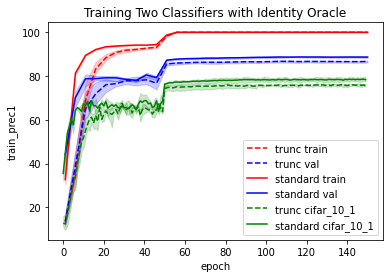

In [25]:
sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', color='red', label='trunc train', linestyle='dashed')
sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', color='blue', label='trunc val', linestyle='dashed')

sns.lineplot(data=base_logs, x='epoch', y='train_prec1', color='red', label='standard train')
sns.lineplot(data=base_logs, x='epoch', y='val_prec1', color='blue', label='standard val')

sns.lineplot(data=trunc_cifar_10_1, x='epoch', y='test_prec1', color='green', label='trunc cifar_10_1', linestyle='dashed')
ax = sns.lineplot(data=cifar_10_1, x='epoch', y='test_prec1', color='green', label='standard cifar_10_1')

ax.set_title('Training Two Classifiers with Identity Oracle')
